# Using EcoFOCIpy to apply a 35hr Lanzcos Filter to 2D data (xarray)

- input:
    - example uses xarray but you can do it via erddap to... it just needs a modification to the read in lines.  erddap hostd adcp data is gridded for vel/ein so erddapy or any other tool should read it into xarry easily
- output is currently only csv files for each depth (exported from a pandas dataframe (so you could just continue analysis)

TODO:
- output to xarray modified netcdf file

In [1]:
import xarray as xa
import pandas as pd
import numpy as np

import EcoFOCIpy.math.lanzcos as lanzcos 
import EcoFOCIpy.plots.TimeSeriesStickPlot as TimeseriesStickPlot

from requests.exceptions import HTTPError
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_to_file = '19bsp11a_0120m.nc'

plotfigs = True
savedata = False
domath = False

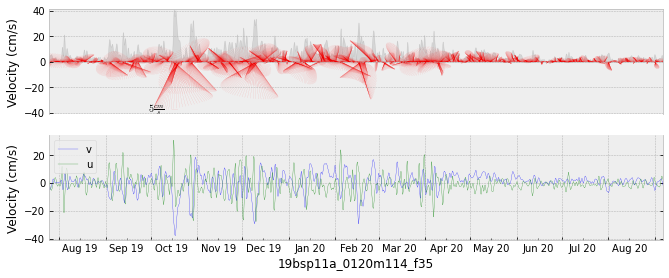

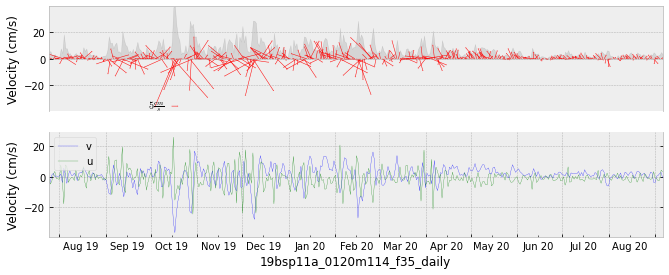

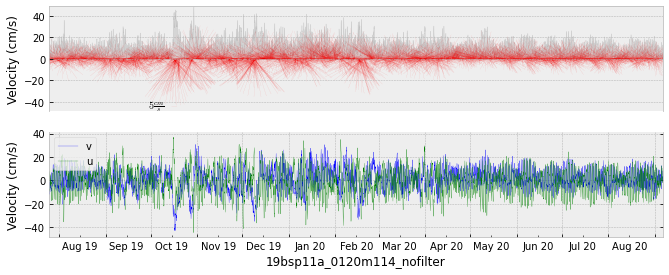

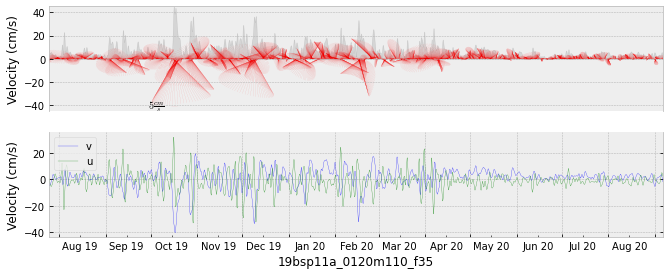

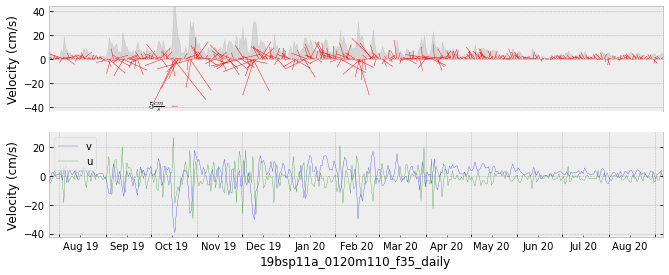

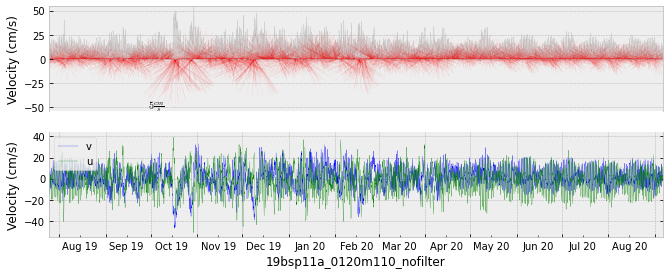

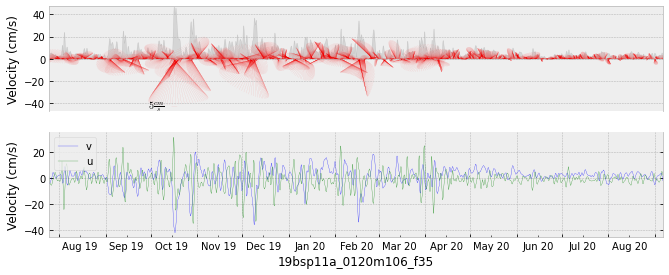

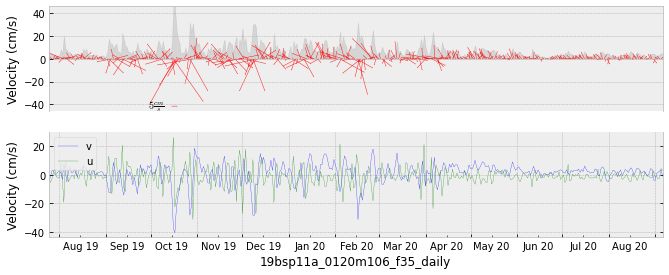

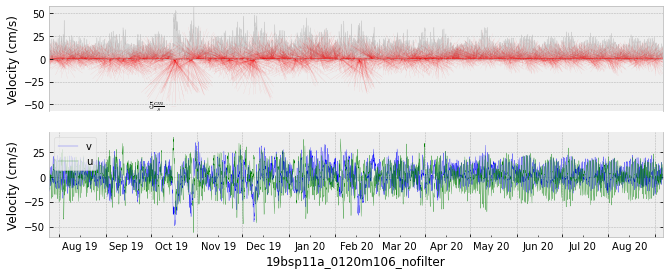

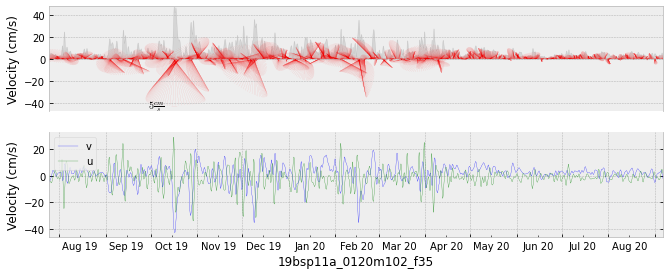

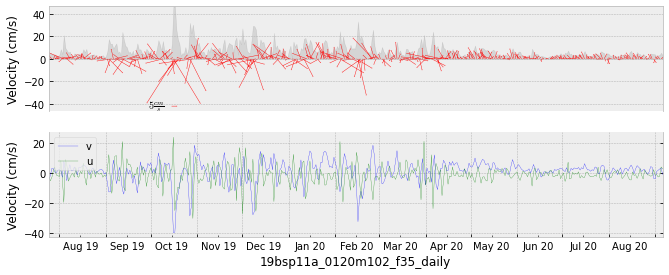

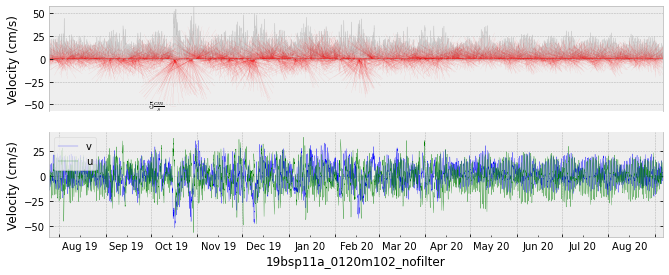

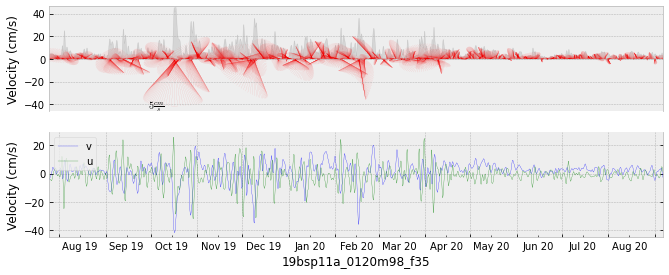

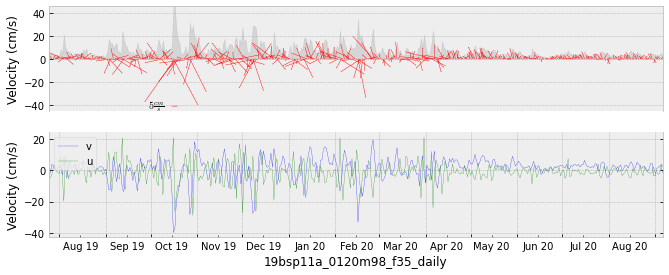

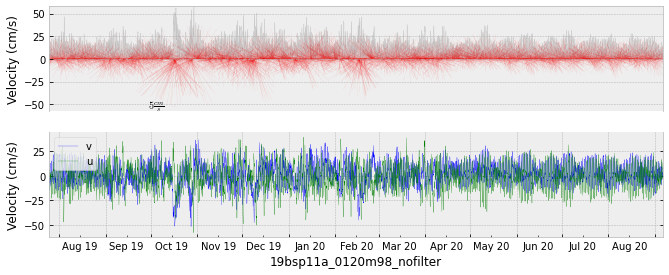

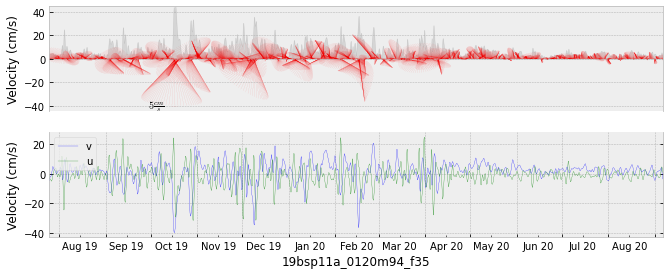

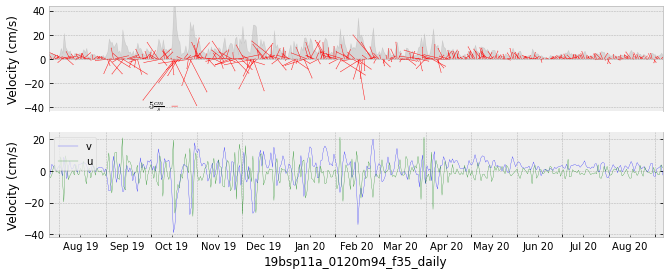

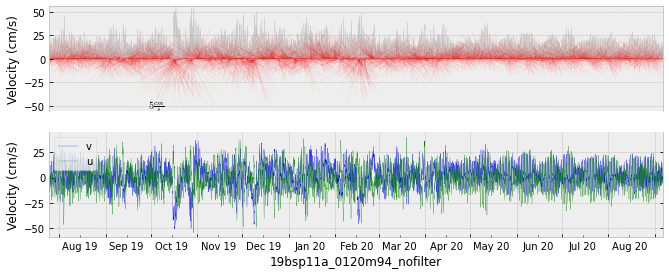

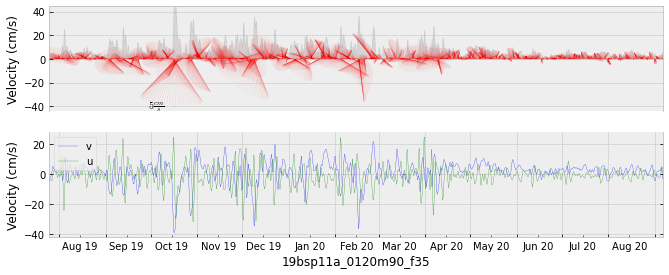

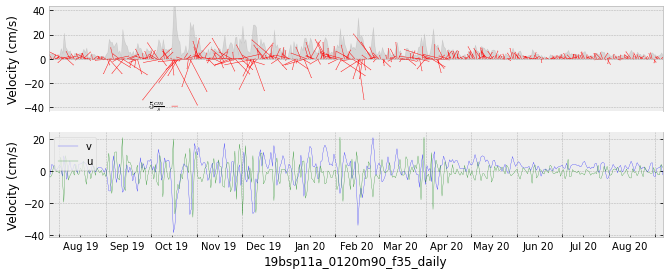

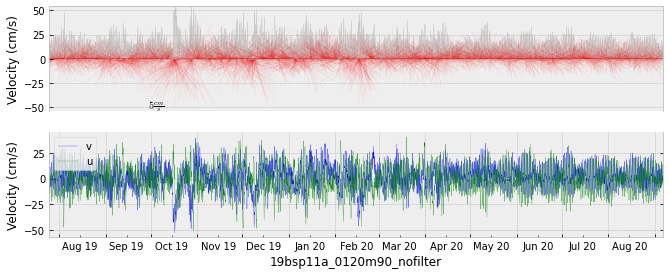

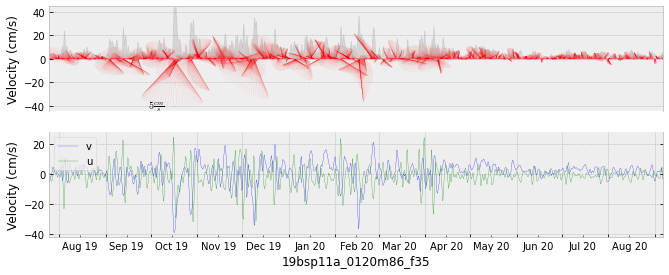

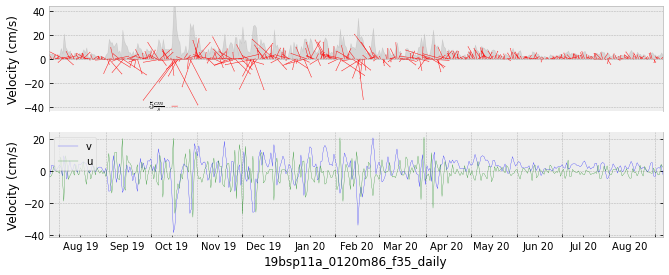

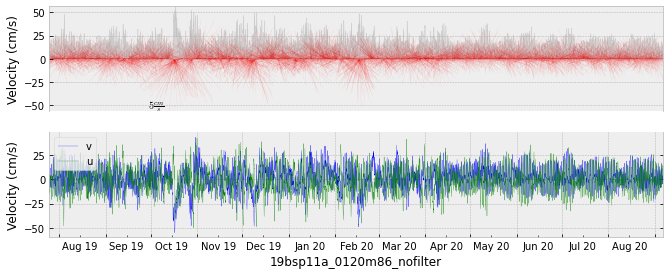

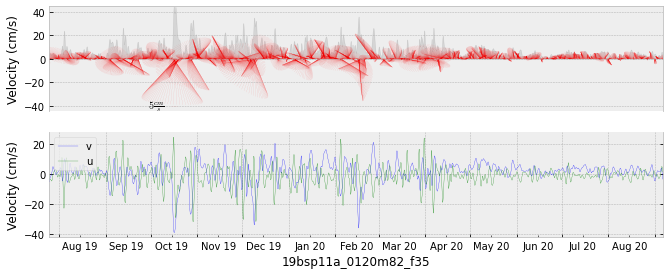

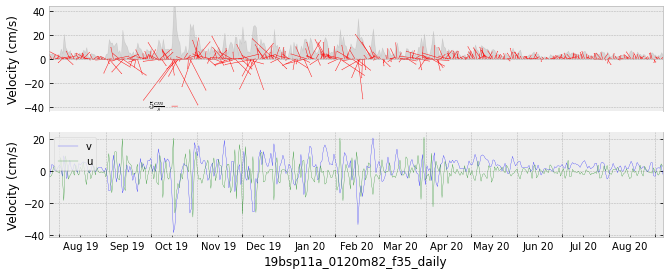

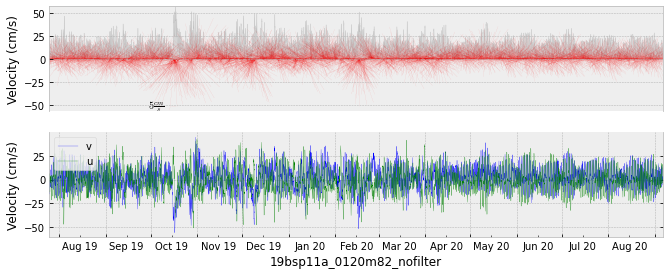

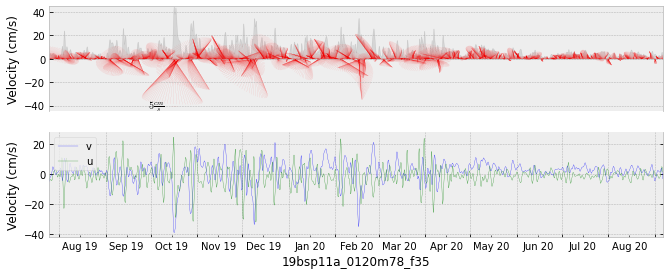

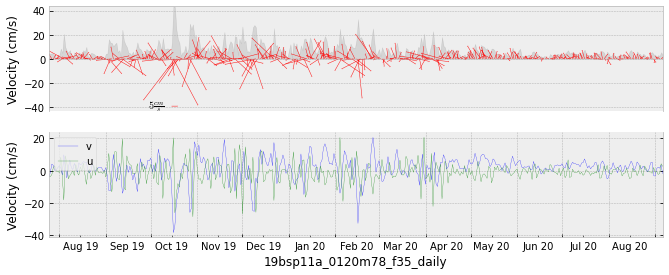

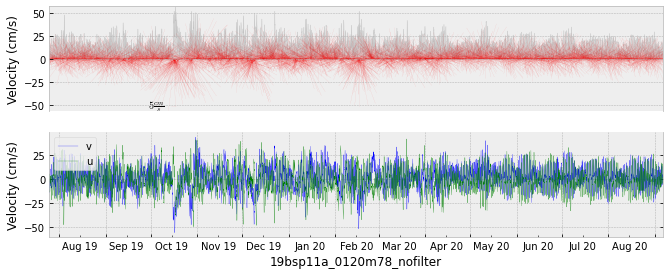

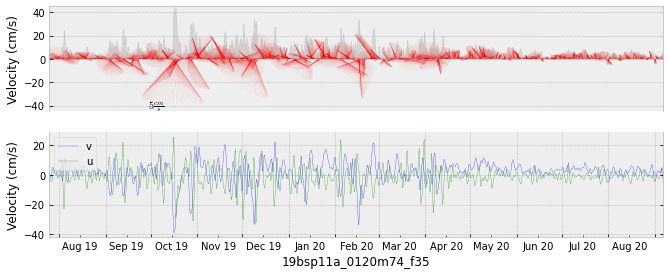

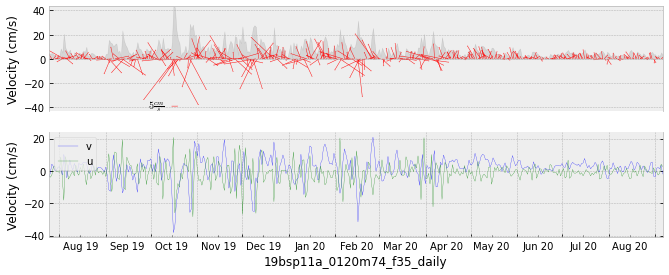

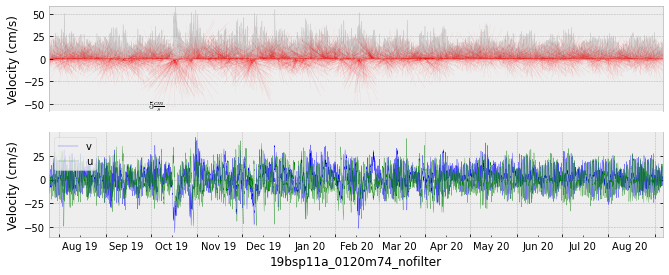

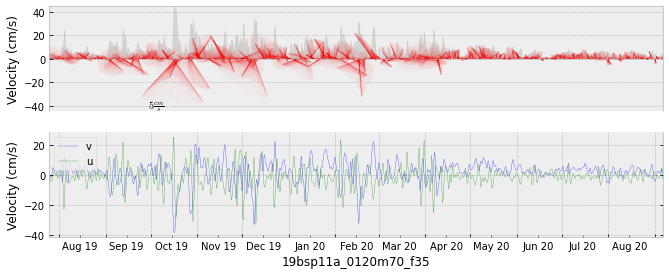

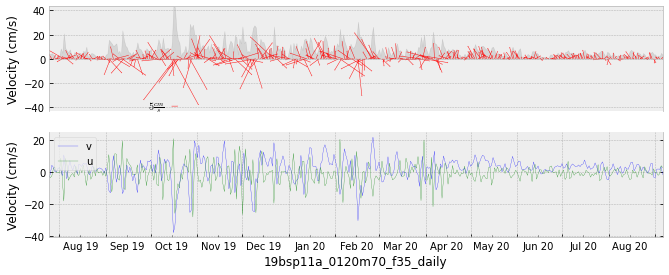

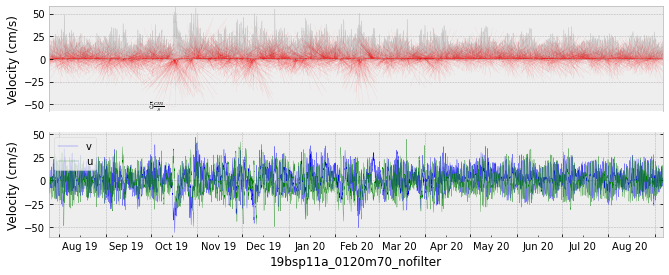

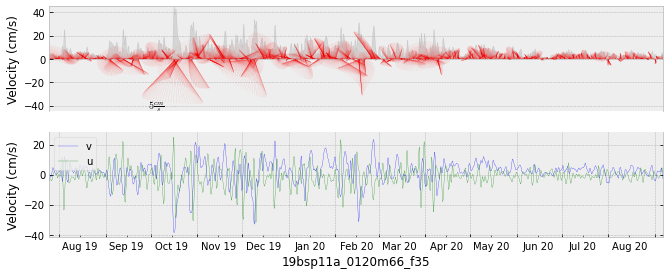

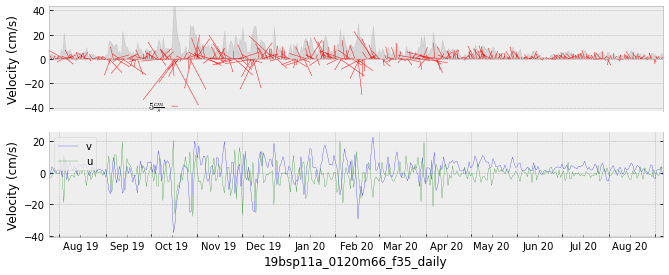

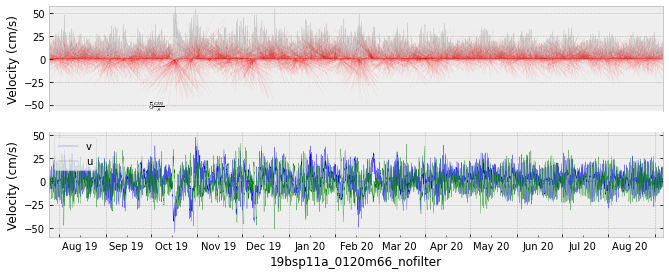

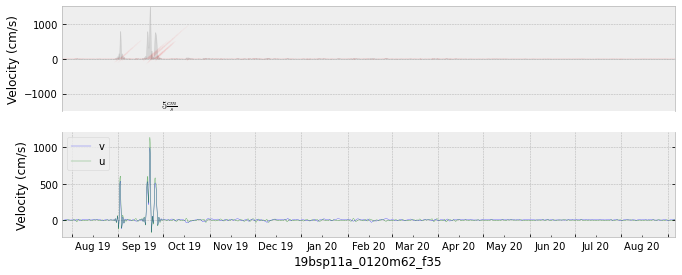

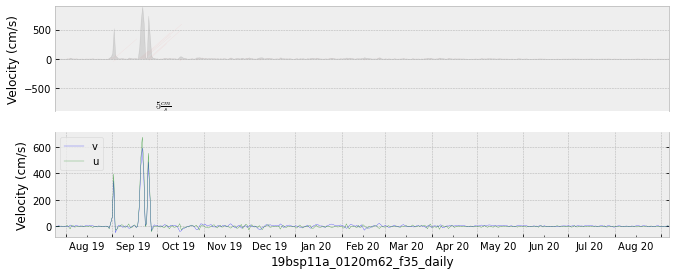

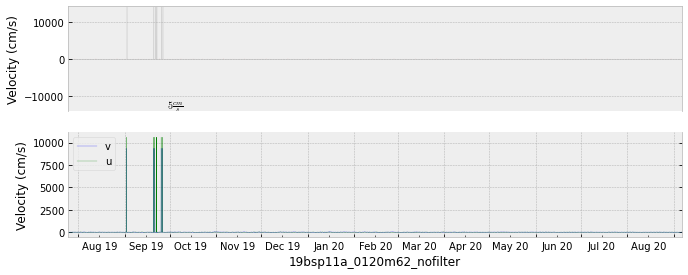

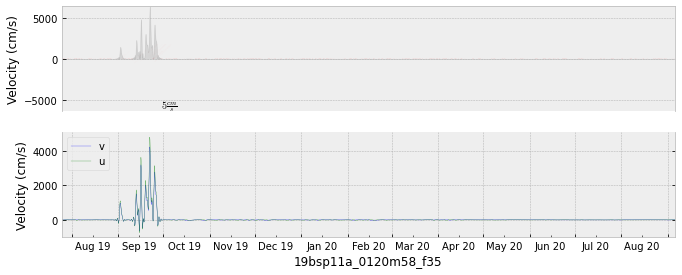

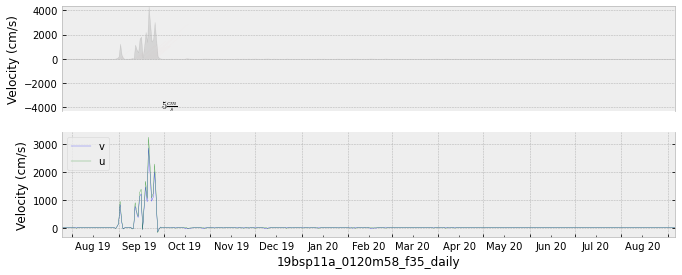

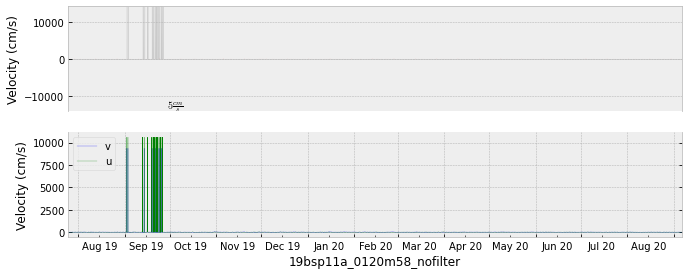

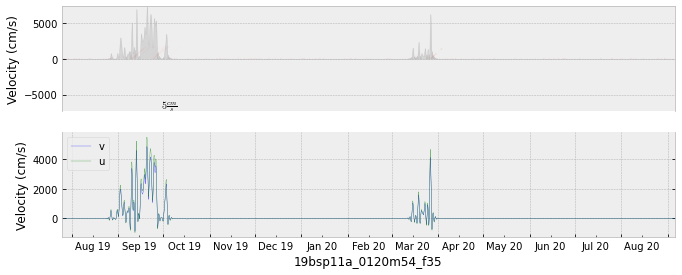

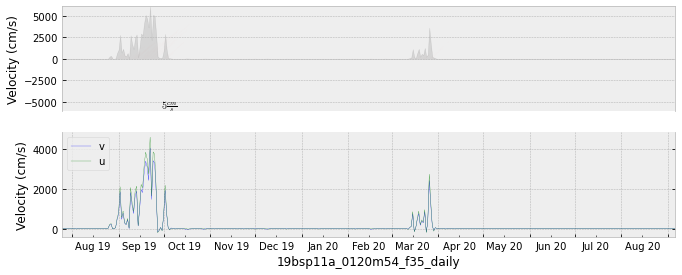

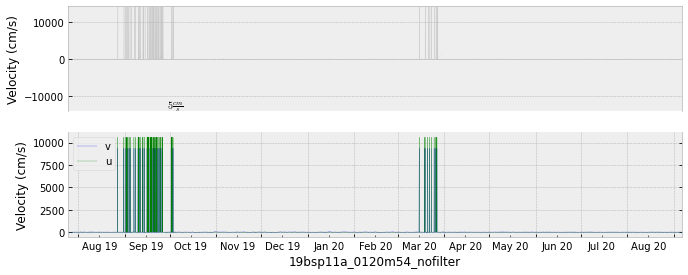

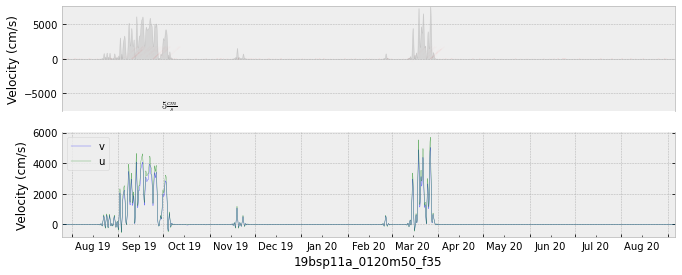

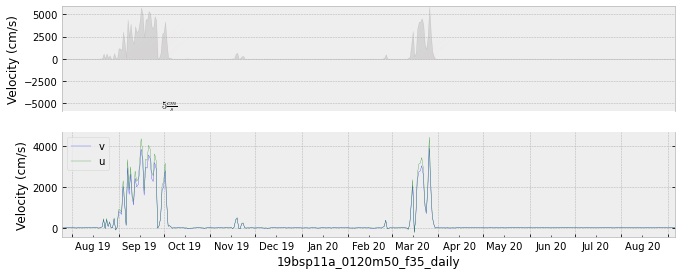

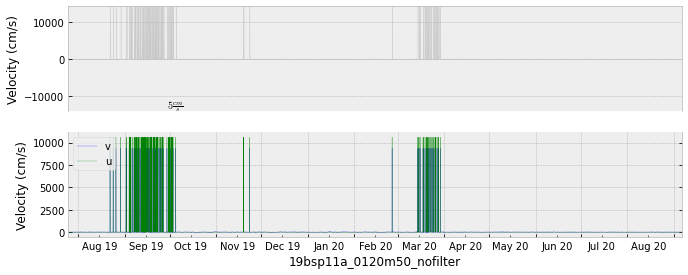

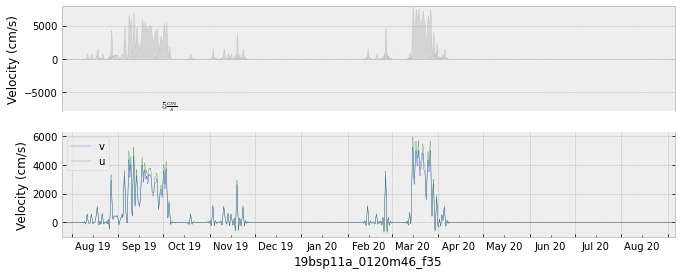

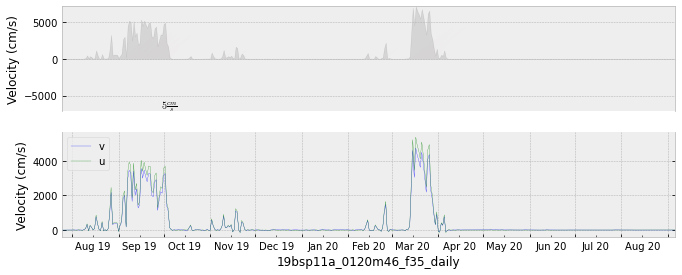

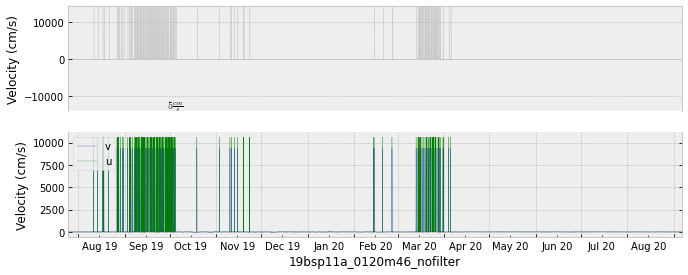

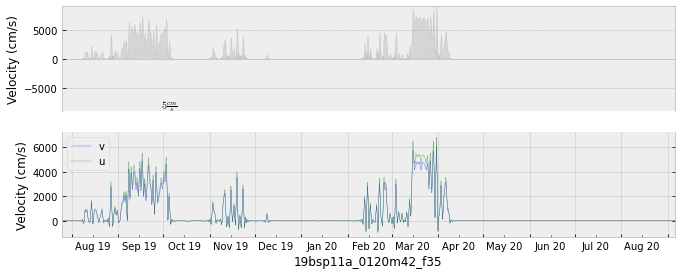

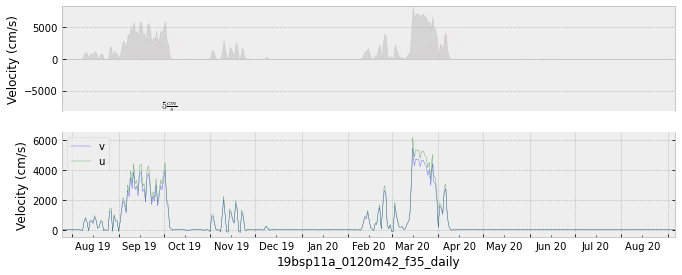

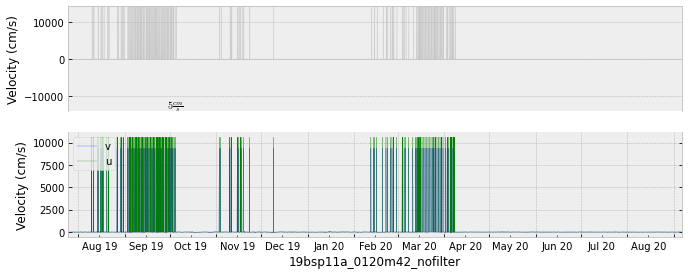

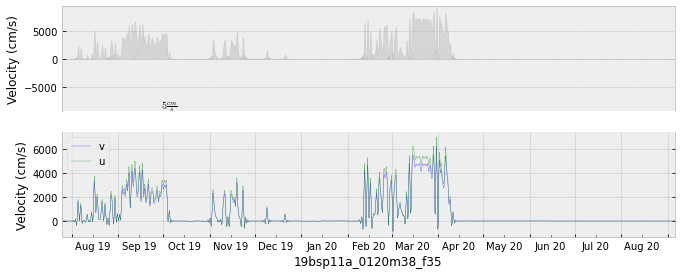

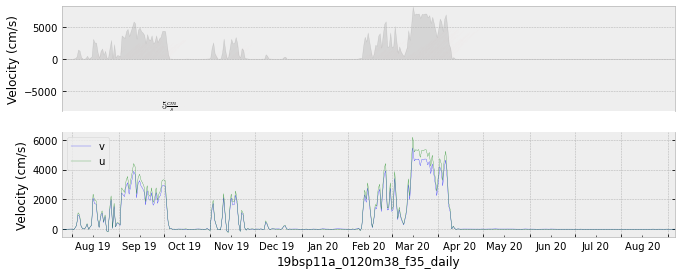

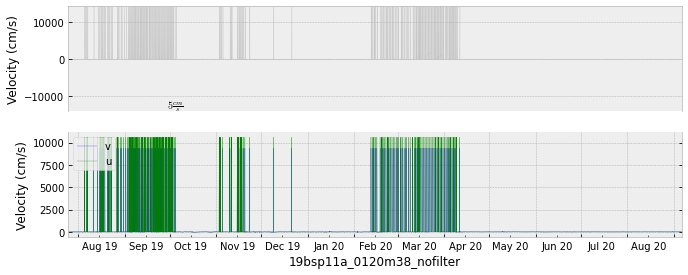

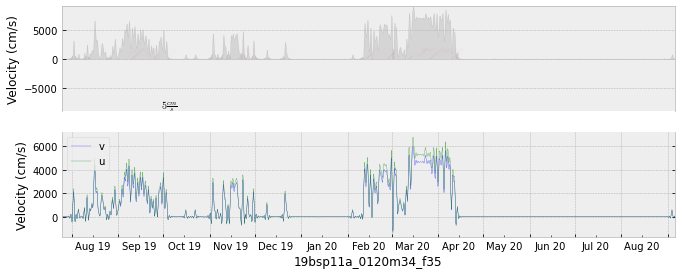

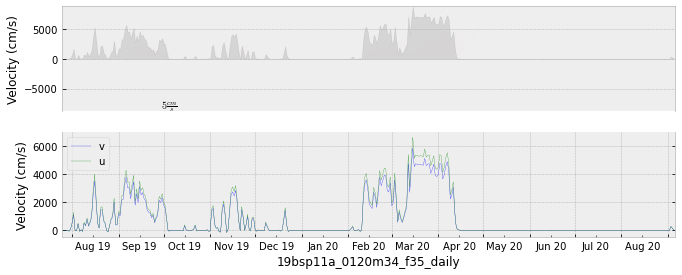

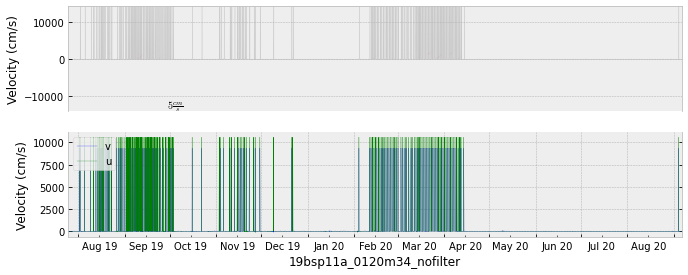

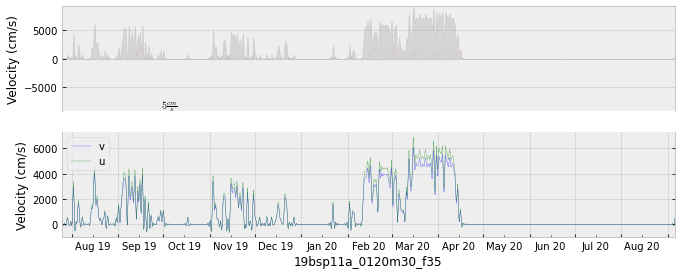

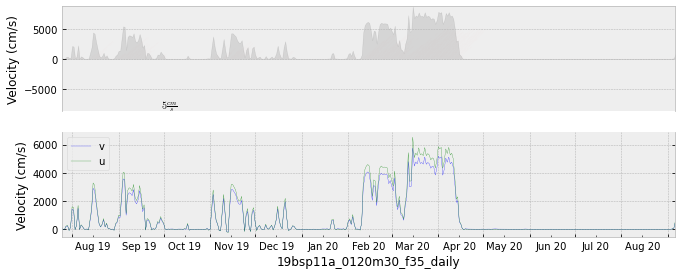

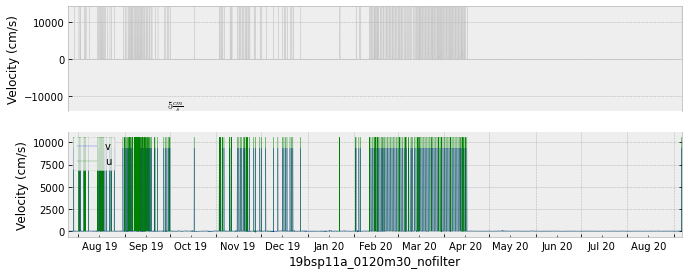

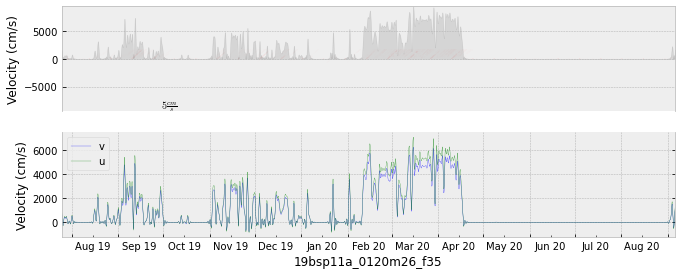

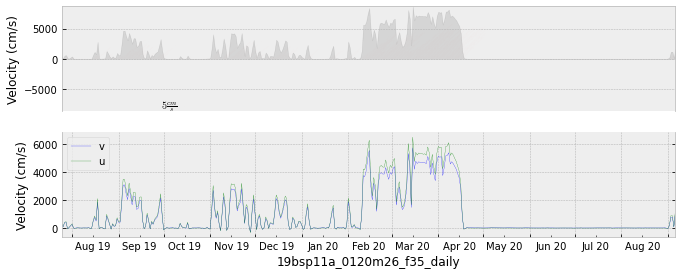

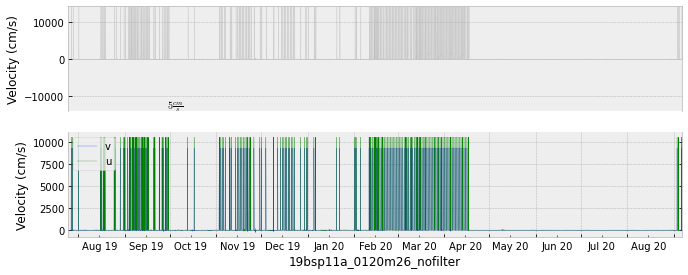

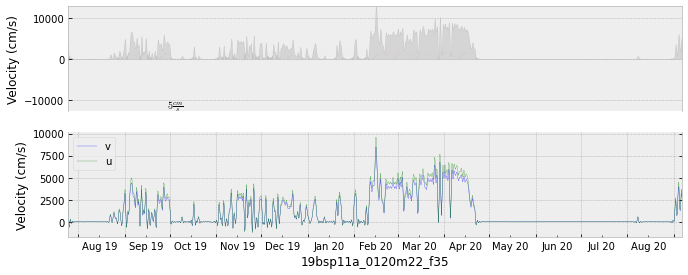

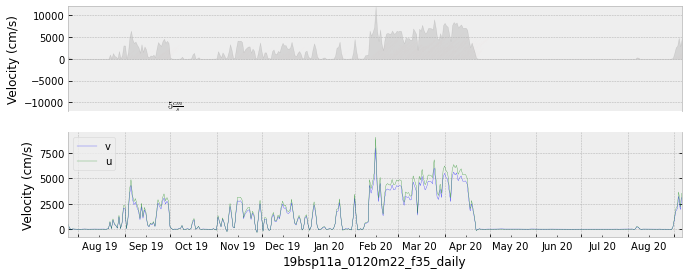

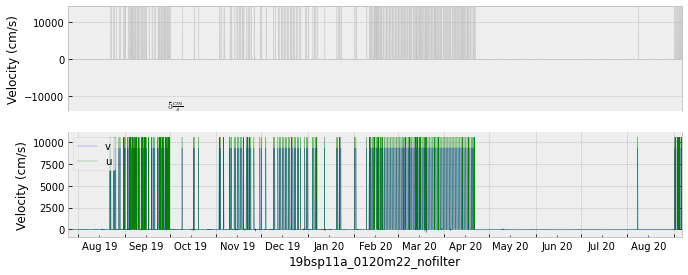

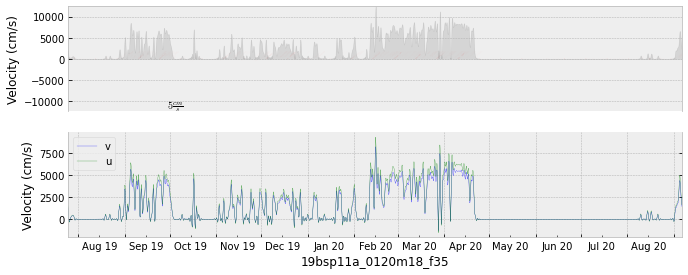

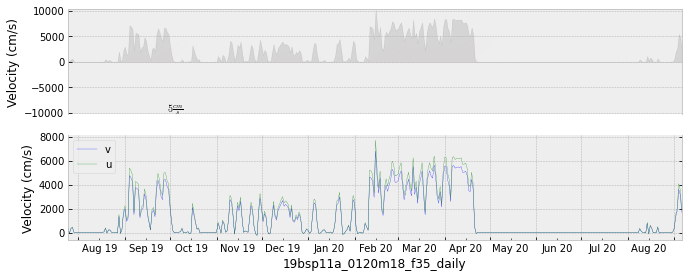

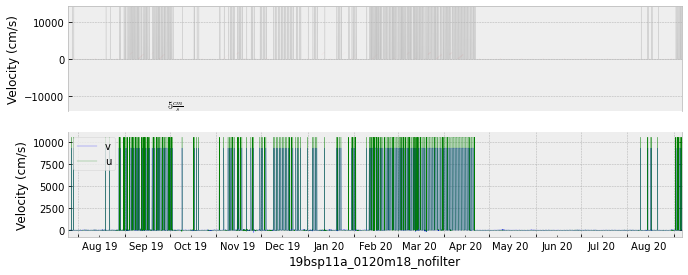

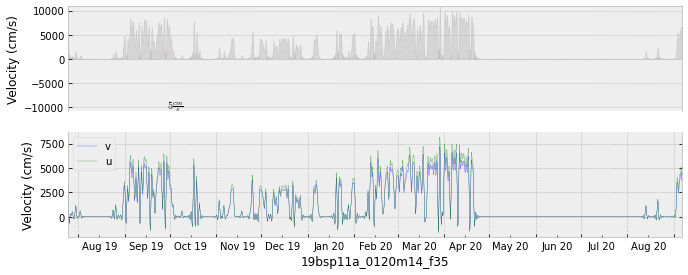

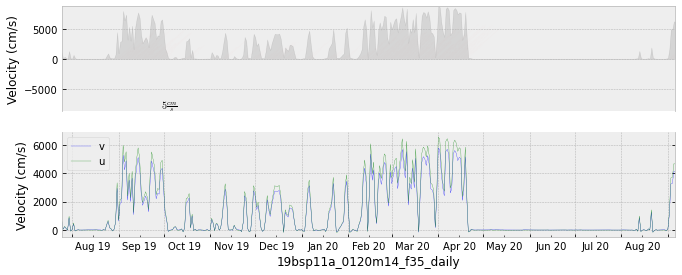

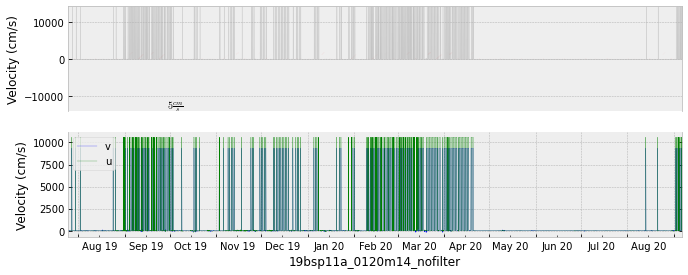

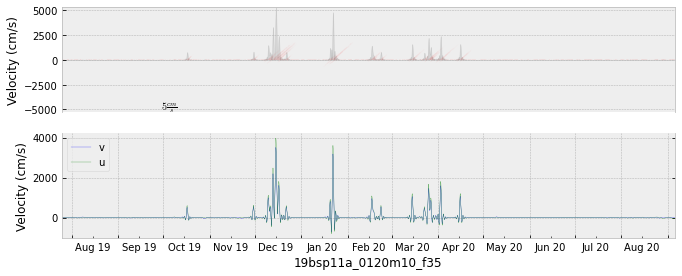

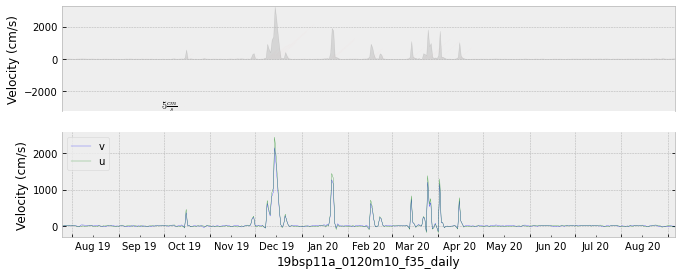

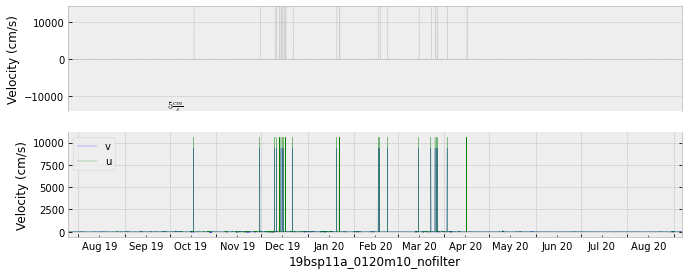

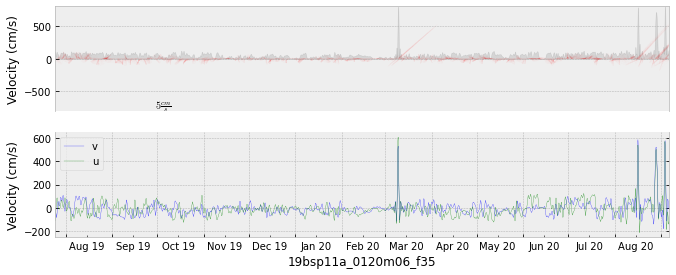

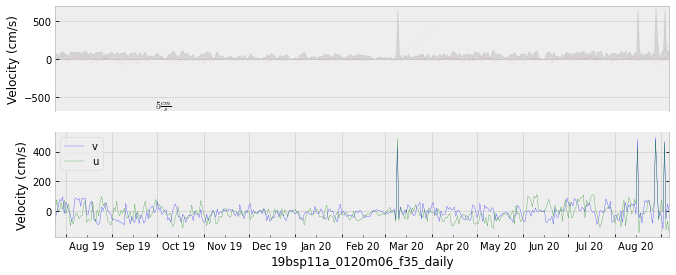

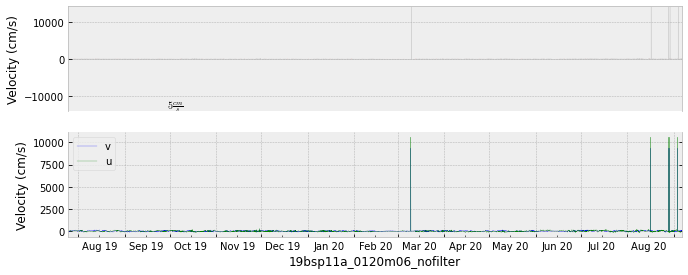

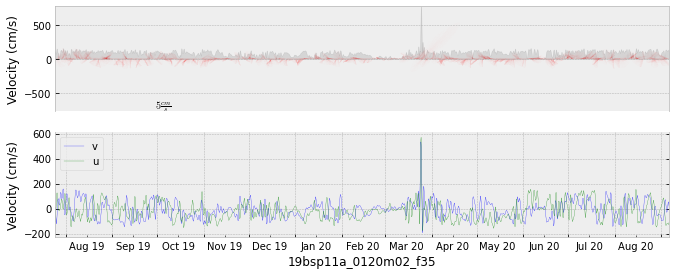

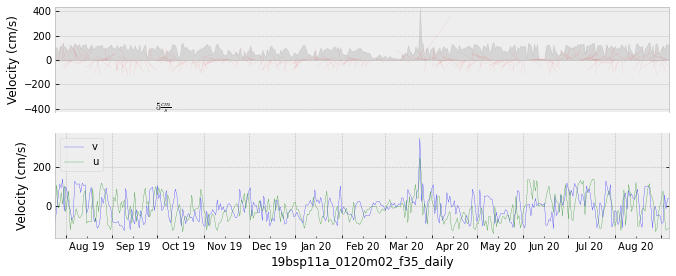

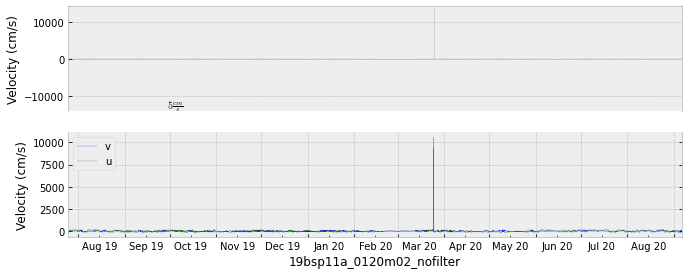

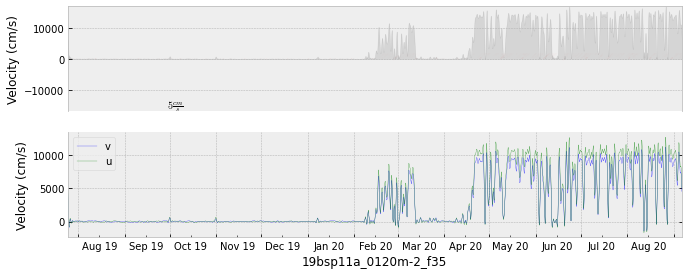

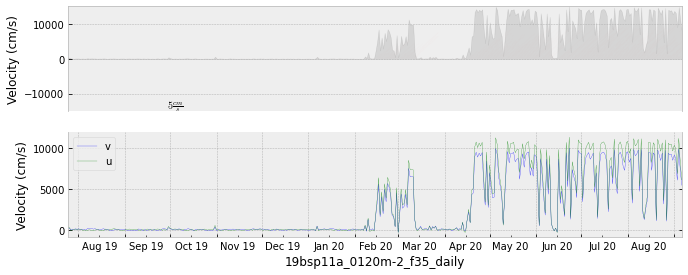

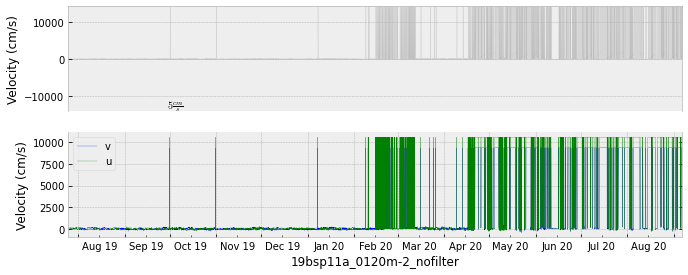

In [3]:
ds = xa.load_dataset(path_to_file)

dataset_id = path_to_file.split('/')[-1].split('.')[0]

for dd in range(ds.depth.size-1,-1,-1):
    depth_curr = ds.isel(depth=dd)

    ### filter
    udata = depth_curr.u_curr_comp[0,0,:].to_pandas()
    vdata = depth_curr.v_curr_comp[0,0,:].to_pandas()

    data = pd.concat([udata, vdata], axis=1)
    data.columns = ['udata','vdata']

    data['udata'][data.udata > 1e34]=np.nan
    data['vdata'][data.vdata > 1e34]=np.nan
    data = data.resample('1H').mean()

    ## missing data fill limited by number of hours to linearly interpolate
    data['tempu'] = data['udata'].interpolate(method='time',limit=6)
    data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index_u = np.isnan(data.tempu)
    missing_index_v = np.isnan(data.tempv)
    data['tempu'] = data['udata'].interpolate(method='time')
    data['tempv'] = data['vdata'].interpolate(method='time')

    #filter data with rudimentary matlab script
    data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
    data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
    data['ufdata'][missing_index_u] = np.nan
    data['vfdata'][missing_index_v] = np.nan    

    #extra calculations
    if domath:
        print(dataset_id)
        print(data.describe()[['ufdata','vfdata']])

    #plot
    if plotfigs:
        try:
            p1 = TimeseriesStickPlot.Timeseries1dStickPlot()
            plt1, fig1 = p1.plot(timedata=data.index, 
                                 udata=data.ufdata.values, 
                                 vdata=data.vfdata.values,
                                 rotate=0)
            plt1.xlabel(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35')
            fig1.savefig(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35'+'.png',dpi=600)


            #subsample
            datasub=data.resample('D').median()
            p1 = TimeseriesStickPlot.Timeseries1dStickPlot()
            plt1, fig1 = p1.plot(timedata=datasub.index, 
                                 udata=datasub.ufdata.values, 
                                 vdata=datasub.vfdata.values,
                                 linescale=10,
                                 rotate=0)
            plt1.xlabel(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35_daily')
            fig1.savefig(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35_daily'+'.png',dpi=600)

            p1 = TimeseriesStickPlot.Timeseries1dStickPlot()
            plt1, fig1 = p1.plot(timedata=data.index, 
                                 udata=data.udata.values, 
                                 vdata=data.vdata.values,
                                 rotate=0)
            plt1.xlabel(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_nofilter')
            fig1.savefig(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_nofilter'+'.png',dpi=600)
        except:
            pass
    #save data
    if savedata:
        data[['ufdata','vfdata']].to_csv(dataset_id+'_'+str(int(ds.depth[dd].values)).zfill(2)+'_f35'+'.csv')